# Задача: определение кредитного рейтинга клиентов

Загружаем данные

In [7]:
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.neighbors import LocalOutlierFactor

# anova model from formula
from statsmodels.formula.api import ols
# anova table from ols model
from statsmodels.stats.anova import anova_lm
# for qqplot
import statsmodels.api as sm
# tukey test
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# correlation
from scipy.stats import pearsonr, spearmanr, kendalltau

data = pd.read_csv(r'C:\Users\David Hilbert\JupyterNotebook Projects\Определяем кредитный рейтинг\credit_risk_dataset.csv')

In [8]:
data

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


Смотрим на наш dataset

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [11]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,32581.0,27.734600,6.348078,20.00,23.00,26.00,30.00,144.00
person_income,32581.0,66074.848470,61983.119168,4000.00,38500.00,55000.00,79200.00,6000000.00
person_emp_length,31686.0,4.789686,4.142630,0.00,2.00,4.00,7.00,123.00
loan_amnt,32581.0,9589.371106,6322.086646,500.00,5000.00,8000.00,12200.00,35000.00
loan_int_rate,29465.0,11.011695,3.240459,5.42,7.90,10.99,13.47,23.22
loan_status,32581.0,0.218164,0.413006,0.00,0.00,0.00,0.00,1.00
loan_percent_income,32581.0,0.170203,0.106782,0.00,0.09,0.15,0.23,0.83
cb_person_cred_hist_length,32581.0,5.804211,4.055001,2.00,3.00,4.00,8.00,30.00


Разделяем датасет на вещественные и категориальные признаки

In [13]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['loan_grade'] = le.fit_transform(data['loan_grade'])

In [14]:
for i, category in enumerate(le.classes_):
    print(f"{category} -> {i}")

A -> 0
B -> 1
C -> 2
D -> 3
E -> 4
F -> 5
G -> 6


In [15]:
numerical_features = list(data.columns[(data.dtypes == 'float64') | (data.dtypes == 'int64') | (data.dtypes == 'int32')])
categorical_features = list(data.columns[data.dtypes == object])

Проверяем датасет на отстствие значений

In [17]:
data[numerical_features].isnull().sum()

person_age                       0
person_income                    0
person_emp_length              895
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_cred_hist_length       0
dtype: int64

In [18]:
data[categorical_features].isnull().sum()

person_home_ownership        0
loan_intent                  0
cb_person_default_on_file    0
dtype: int64

Отсутствующих значений немного, поэтому удалим эти строки

In [20]:
data = data.dropna()

Кодируем категориальные признаки

In [22]:
from sklearn.preprocessing import OneHotEncoder

# Ваши категориальные признаки
categorical_features = list(data.columns[data.dtypes == object])

# Инициализация энкодера
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # sparse=False для получения массива numpy

# Обучение энкодера на категориальных признаках
encoder.fit(data[categorical_features])

# Получение закодированных признаков как массив numpy
encoded_features = encoder.transform(data[categorical_features])

# Генерация названий новых признаков
categories = []
for i, feature in enumerate(categorical_features):
    categories.extend([f'{feature}: {category}' for category in encoder.categories_[i]])

# Создание DataFrame с закодированными признаками
encoded_df = pd.DataFrame(encoded_features, columns=categories, index=data.index)

# Объединение с исходным датафреймом
data = pd.concat([data, encoded_df], axis=1)

# Опционально: удалите исходные категориальные признаки
# data.drop(categorical_features, axis=1, inplace=True)

<Axes: xlabel='person_age'>

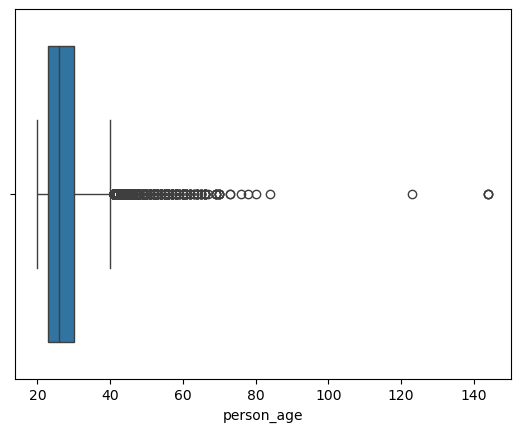

In [23]:
sns.boxplot(data=data, x='person_age')

Удалим данные, где людям больше 90 лет

In [25]:
data=data[data.person_age < 90]

Анализируем датасет на наличие выбросов

In [27]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05) 

# Обучение и предсказание
# LOF возвращает -1 для выбросов, 1 для нормальных точек
X = data[numerical_features]
pred = lof.fit_predict(X)

# Добавим результат в датафрейм
data['LOF_outlier'] = pred

# Отфильтруем выбросы
outliers = data[data['LOF_outlier'] == -1]

print("Обнаруженные выбросы:")
print(outliers)

Обнаруженные выбросы:
       person_age  person_income person_home_ownership  person_emp_length  \
518            23          99996                  RENT                3.0   
542            24          65000                  RENT                4.0   
553            26          65219                  RENT               11.0   
554            22          75000                  RENT                2.0   
558            23          80000                  RENT                3.0   
...           ...            ...                   ...                ...   
32451          51          45000                  RENT                2.0   
32454          54          65000              MORTGAGE                4.0   
32457          59          42000                  RENT               14.0   
32474          55          75000              MORTGAGE                6.0   
32572          52          52000                   OWN                0.0   

             loan_intent  loan_grade  loan_amnt  loan

# Обучение модели

In [29]:
from sklearn.model_selection import train_test_split

train_features = numerical_features + categories
train_features.remove('loan_grade')

X = data[train_features]
y = data['loan_grade']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24)

### 1. Линейная регрессия

In [31]:
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# Определите диапазон значений alpha, которые хотите проверить
param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}


# Создаем модель Ridge
ridge = RidgeClassifier()

# Настраиваем GridSearchCV
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# Обучение моделей и поиск лучших гиперпараметров
grid_search.fit(X_train, y_train)

# Лучшие параметры
print("Лучшее значение alpha:", grid_search.best_params_)

# Лучшая модель
best_model = grid_search.best_estimator_

# Предсказания на тестовых данных
predictions = best_model.predict(X_test)

Лучшее значение alpha: {'alpha': 0.01}


Создаем функцию, которая будет выдавать метрики

In [33]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def get_metrics(model, X_test, y_test):
    # Попытка получить предсказания
    try:
        y_pred = model.predict(X_test)
    except AttributeError:
        # Если у модели есть predict_proba, а не predict
        try:
            y_pred_probs = model.predict_proba(X_test)
            y_pred = np.argmax(y_pred_probs, axis=1)
        except AttributeError:
            raise ValueError("Модель должна иметь метод predict() или predict_proba()")
    
    # Проверка и приведение y_pred к меткам, если необходимо
    if hasattr(y_pred, 'ndim') and y_pred.ndim > 1:
        y_pred = np.argmax(y_pred, axis=1)

    # Если y_test — строки, нужно преобразовать в числа
    if isinstance(y_test.iloc[0], str):
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        y_test = le.fit_transform(y_test)
    
    # Метрика точности
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}\n")
    print("Classification report:\n", classification_report(y_test, y_pred))
    
    # Матрица ошибок
    cm = confusion_matrix(y_test, y_pred)
    
    # Визуализация
    plt.figure(figsize=(8, 6))
    try:
        class_labels = model.classes_
    except AttributeError:
        class_labels = None
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

Смотрим метрики

Accuracy: 0.6748

Classification report:
               precision    recall  f1-score   support

           0       0.79      1.00      0.88      2829
           1       0.59      0.74      0.65      2741
           2       0.61      0.47      0.53      1724
           3       0.53      0.16      0.25       965
           4       0.00      0.00      0.00       243
           5       0.00      0.00      0.00        70
           6       0.00      0.00      0.00        19

    accuracy                           0.67      8591
   macro avg       0.36      0.34      0.33      8591
weighted avg       0.63      0.67      0.63      8591



C:\Program Files\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Program Files\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Program Files\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


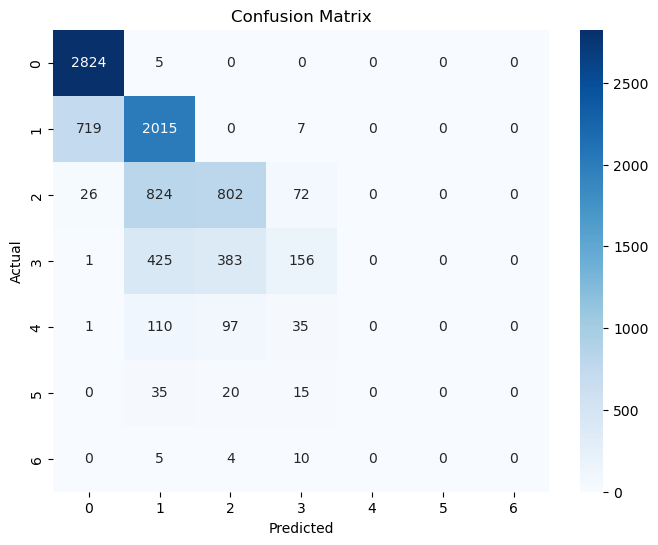

In [35]:
get_metrics(best_model, X_test, y_test)

### Метрики нас не устраивают, пробуем улучшить с помощью oversampling

In [37]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=24)

In [39]:
# Определите диапазон значений alpha, которые хотите проверить
param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}


# Создаем модель Ridge
ridge = RidgeClassifier(class_weight='balanced')

# Настраиваем GridSearchCV
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# Обучение моделей и поиск лучших гиперпараметров
grid_search.fit(X_train, y_train)

# Лучшие параметры
print("Лучшее значение alpha:", grid_search.best_params_)

# Лучшая модель
best_model = grid_search.best_estimator_

# Предсказания на тестовых данных
predictions = best_model.predict(X_test)

C:\Program Files\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.01887e-16): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Program Files\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.06668e-16): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Program Files\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.01666e-16): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Program Files\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.01268e-16): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Program Files\anaconda3\Lib\site-packages\sklearn\linear_model\_r

Лучшее значение alpha: {'alpha': 100}


Accuracy: 0.4568

Classification report:
               precision    recall  f1-score   support

           0       0.49      1.00      0.66      2747
           1       0.37      0.21      0.27      2891
           2       0.47      0.47      0.47      2862
           3       0.61      0.13      0.22      2782
           4       0.51      0.04      0.07      2803
           5       0.46      0.43      0.44      2876
           6       0.43      0.94      0.59      2784

    accuracy                           0.46     19745
   macro avg       0.48      0.46      0.39     19745
weighted avg       0.47      0.46      0.39     19745



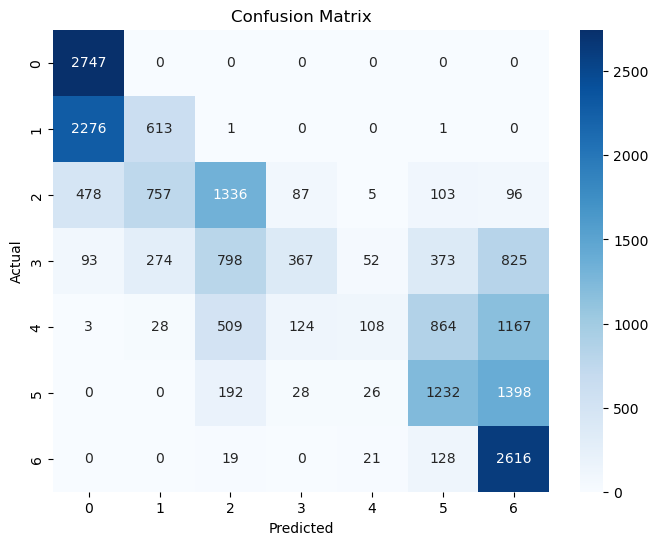

In [40]:
get_metrics(best_model, X_test, y_test)

Метрики нас по-прежнему не устраивают, пробуем другие модели

### 2. Пробуем нейросеть

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Допустим, у вас есть массивы dataX (признаки) и dataY (классы)
dataX = X
dataY = y


# Масштабирование признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разделение данных
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# Преобразование в тензеры
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long)
y_val_tensor = torch.tensor(y_val.to_numpy(), dtype=torch.long)

# Создаем DataLoader для обучения и валидации (по желанию)
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32)

# Определение модели
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleMLP, self).__init__()
        self.hidden_layer1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.hidden_layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.relu(self.hidden_layer1(x))
        x = self.dropout(x)
        x = self.relu(self.hidden_layer2(x))
        x = self.dropout(x)
        x = self.output_layer(x)
        return x

# Инициализация модели
input_dim = X_train.shape[1]
hidden_dim = 128
output_dim = len(np.unique(y))
model = SimpleMLP(input_dim, hidden_dim, output_dim)

# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Обучение модели
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)   

print("Обучение завершено.")

Обучение завершено.


              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1880
           1       0.92      0.96      0.94      1830
           2       0.89      0.83      0.86      1139
           3       0.71      0.81      0.76       650
           4       0.49      0.25      0.33       174
           5       0.42      0.31      0.36        42
           6       0.50      0.25      0.33        12

    accuracy                           0.90      5727
   macro avg       0.70      0.63      0.65      5727
weighted avg       0.89      0.90      0.89      5727



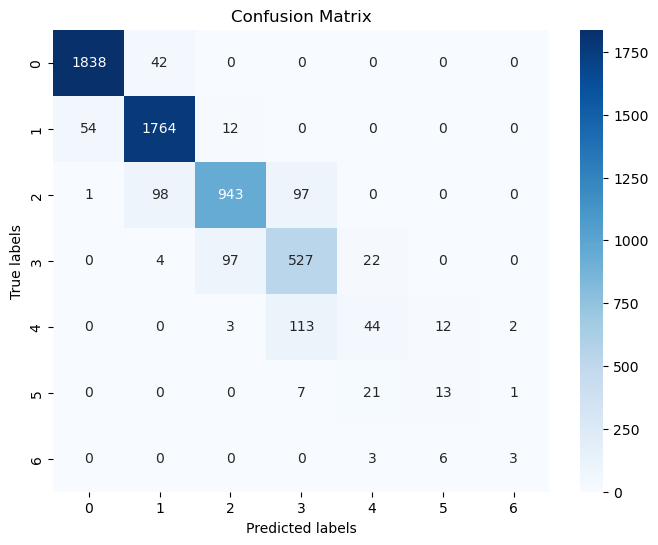

In [44]:
from sklearn.metrics import classification_report, confusion_matrix

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch_X, batch_y in val_loader:
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

# Теперь можно вычислить метрики
print(classification_report(all_labels, all_preds))
# Матрица ошибок
cm = confusion_matrix(all_labels, all_preds)

# Визуализация матрицы
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(all_labels),
            yticklabels=np.unique(all_labels))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Метрики стали лучше, хотя модель совсем не распознает 5-ый класс. Пробуем другую модель.

In [46]:
import tensorflow as tf

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разделение данных
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, stratify=y)

# Создание модели
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(len(np.unique(y)), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Обучение
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, verbose=1)]
)

C:\Program Files\anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):
C:\Program Files\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
716/716 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7342 - loss: 0.6964 - val_accuracy: 0.8673 - val_loss: 0.3714
Epoch 2/50
716/716 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8418 - loss: 0.4150 - val_accuracy: 0.8825 - val_loss: 0.3257
Epoch 3/50
716/716 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8630 - loss: 0.3675 - val_accuracy: 0.8786 - val_loss: 0.3138
Epoch 4/50
716/716 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8683 - loss: 0.3500 - val_accuracy: 0.8844 - val_loss: 0.3023
Epoch 5/50
716/716 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8726 - loss: 0.3354 - val_accuracy: 0.8792 - val_loss: 0.3140
Epoch 6/50
716/716 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8769 - loss: 0.3263 - val_accuracy: 0.8876 - val_loss: 0.3016
Epoch 7/50
716/716 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8782 - loss: 0.3225 - val_accuracy: 0.8858 - val_loss: 0.3012
Epoch 8/50
716/716 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8772 - loss: 0.3172 - val_accuracy: 0.

In [47]:
# Предсказание на валидационной выборке
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step


Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.97      1880
           1       0.92      0.94      0.93      1830
           2       0.87      0.85      0.86      1139
           3       0.73      0.76      0.75       650
           4       0.50      0.35      0.41       174
           5       0.22      0.05      0.08        42
           6       0.00      0.00      0.00        12

    accuracy                           0.89      5727
   macro avg       0.60      0.56      0.57      5727
weighted avg       0.88      0.89      0.88      5727



C:\Program Files\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Program Files\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Program Files\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


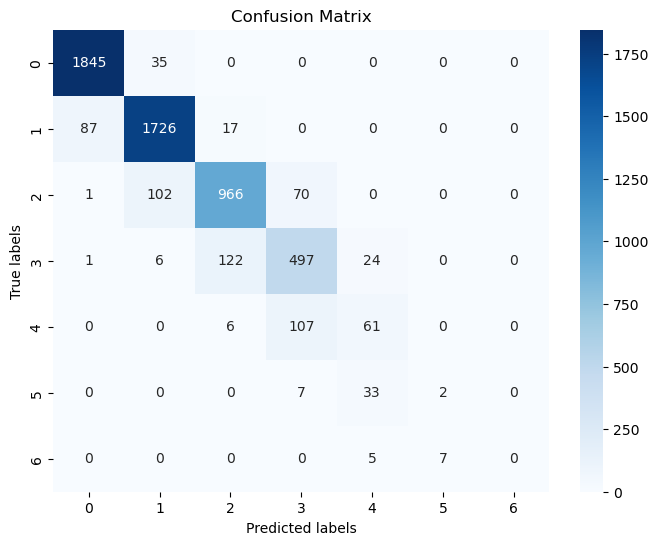

In [48]:
# Метрики
print("Classification Report:\n", classification_report(y_val, y_pred))

# Матрица ошибок
cm = confusion_matrix(y_val, y_pred)

# Визуализация матрицы ошибок
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y), 
            yticklabels=np.unique(y))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Данная модель лучше распознает классы, пробуем другую модель

### 3. CatBoost

In [51]:
train_features = numerical_features + categories
train_features.remove('loan_grade')

X = data[train_features]
y = data['loan_grade']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24)

In [52]:
# Параметры для CatBoost
param_grid_cb = {
    'iterations': [10, 50, 100, 200],               # Количество деревьев
    'depth': [4, 6, 8, 12, 20],                     # Максимальная глубина дерева
    'learning_rate': [0.01, 0.1, 0.5, 2.0],           # Скорость обучения
}

In [53]:
from catboost import CatBoostClassifier

# для CatBoost
grid_cb = GridSearchCV(
    estimator=CatBoostClassifier(verbose=0),
    param_grid=param_grid_cb,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)
grid_cb.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


C:\Program Files\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
80 fits failed out of a total of 400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
80 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Program Files\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Program Files\anaconda3\Lib\site-packages\catboost\core.py", line 5245, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline, use_best_model,
  File "C:\Program Files\anaconda3\Lib\site-packages\catboost\core.p

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x000001F75177E0C0>,
             n_jobs=-1,
             param_grid={'depth': [4, 6, 8, 12, 20],
                         'iterations': [10, 50, 100, 200],
                         'learning_rate': [0.01, 0.1, 0.5, 2.0]},
             scoring='neg_mean_squared_error', verbose=1)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2829
           1       0.97      0.98      0.98      2741
           2       0.97      0.96      0.97      1724
           3       0.95      0.94      0.94       965
           4       0.92      0.81      0.86       243
           5       0.75      0.57      0.65        70
           6       0.59      0.53      0.56        19

    accuracy                           0.97      8591
   macro avg       0.88      0.83      0.85      8591
weighted avg       0.97      0.97      0.97      8591



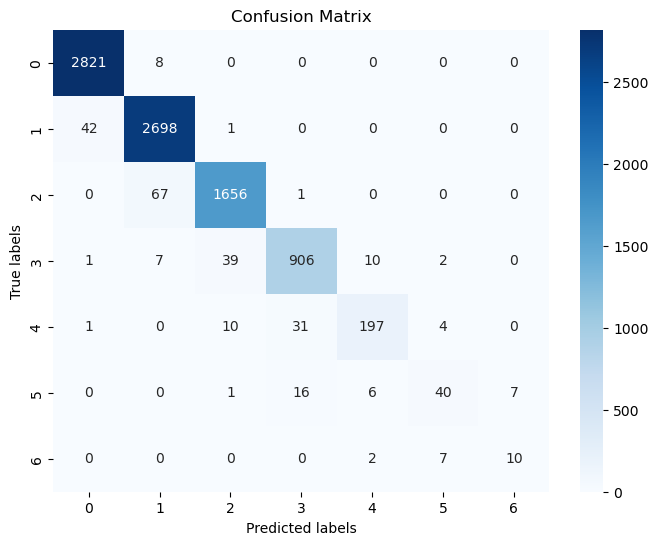

In [57]:
# Предсказания модели
all_preds = grid_cb.predict(X_test)

# Истинные метки (замените на вашу переменную, где хранятся true labels)
all_labels = y_test

# Метрики
print(classification_report(all_labels, all_preds))

# Матрица ошибок
cm = confusion_matrix(all_labels, all_preds)

# Визуализация
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(all_labels),
            yticklabels=np.unique(all_labels))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Итог: для модели CatBoost получили лучшие метрики